# 95-869: Big Data and Large-Scale Computing Homework 5


## **Yelp Dataset Assignment**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset_challenge/). It is an opportunity for you to explore machine learning tasks in the context of a real-world data set using big data analysis tools. In order to use the dataset and finish this project, you must agree to the dataset's terms of use provided [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset_challenge/dataset).

#### ** This assignment will cover: **
*  *Part 1 (30 Points):* Exploratory Data Analysis [Link](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#module-pyspark.mllib.stat)
*  *Part 2 (15 Points):* Prediction using tree ensemble methods [Link](https://spark.apache.org/docs/2.2.0/mllib-ensembles.html)
*  *Part 3 (20 Points):* Collaborative filtering for recommendation [Link](https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html)
*  *Part 4 (15 Points):* Topic modeling for text reviews [Link](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda)
*  *Part 5 (10 Points):* Word2Vec for text reviews [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.feature.Word2Vec)
*  *Part 6 (10 Points):* Frequent pattern mining using FP-Growth algorithm [Link](https://spark.apache.org/docs/2.2.0/mllib-frequent-pattern-mining.html)
*  *Part 7 (Bonus: 20 Points):* Any additional and insightful exploratory data analysis or machine learning tasks you want to do.

#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Code of Conduct **

** Please follow the following guidelines with respect to collaboration: **

* By using the dataset, you agree to Yelp's terms of use available [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).
* You are free to use the Web, APIs, ML toolkits, etc. in this project to your best benefit. Please cite any online or offline sources (even casual sources like StackOverflow) if you use them in the project.
* The assignment is to be done individually. No collaboration is allowed between students. No discussion is allowed about the project with anyone else except the class instructors.

## Submission Instructions:

You will submit both a PDF and an IPython file on Canvas. No printout submission is expected.

Rename the notebook from "hw5_yelp_student.ipynb" to "andrewid_hw5_yelp_student.ipynb" where "andrewid" is your actual Andrew ID. Complete the assignment, execute all cells in the completed notebook, and make sure all results show up. Export the contents of the notebook by choosing "File > Download as > HTML" and saving the resulting file as "andrewid_hw5_yelp_student.html" Convert the exported HTML file to PDF by using a feature such as the "Save as PDF" feature on Mac. Submit the IPython and exported PDF solution files on Canvas.

# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Let's first start by creating the SparkContext.

In [2]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.4-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [3]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/pylon5/ci5619p/benh/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [4]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/pylon5/ci5619p/benh/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/pylon5/ci5619p/benh/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/pylon5/ci5619p/benh/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/pylon5/ci5619p/benh/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/pylon5/ci5619p/benh/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.

Please replace `<FILL IN>` with your solution. This is the general form that exercises will take. Exercises will include an explanation of what is expected, followed by code cells where one cell will have one or more `<FILL IN>` sections.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715
Number of checkins:  45166
Number of reviews:  62608


** Question: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
# TODO: Replace <FILL IN>
category_count=businesses_rdd.flatMap(lambda line:line['categories']).map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).takeOrdered(5,lambda x:-x[1])
print(category_count)

[('Restaurants', 21892), ('Shopping', 8919), ('Food', 7862), ('Beauty & Spas', 4738), ('Nightlife', 4340)]


** Question: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
# TODO: Replace <FILL IN>
city_count=businesses_rdd.map(lambda line:(line['city'],1)).reduceByKey(lambda x,y:x+y).takeOrdered(5,lambda x:-x[1])
print(city_count)

[('Las Vegas', 13601), ('Phoenix', 8410), ('Charlotte', 4224), ('Scottsdale', 4039), ('Edinburgh', 3031)]


** Question: ** Plot the histogram of stars received by businesses.

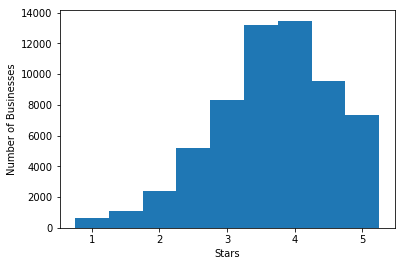

In [11]:
# TODO: Replace <FILL IN>

businesses_stars_counts = businesses_rdd.map(lambda line:line['stars']).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question: ** Plot the histogram of number of reviews received by businesses.

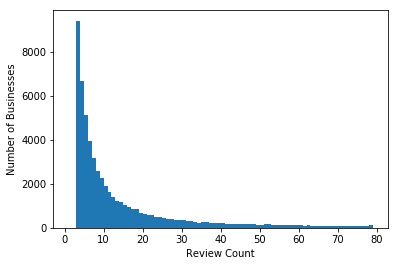

In [12]:
# TODO: Replace <FILL IN>

businesses_review_counts = businesses_rdd.map(lambda line:line['review_count']).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** By plotting the histogram into log-log scale, it shows a linear relationship. This indicates the original one is Power Law. Reason: f(x)=ax^-k --> logf(x)=-k*log(ax)

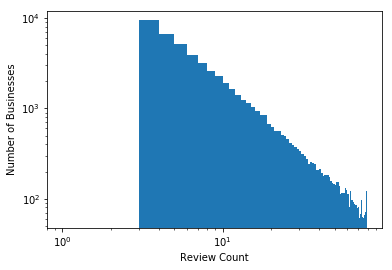

In [13]:
# TODO: Replace <FILL IN>
plt.hist(businesses_review_counts, bins=range(1,80),log=True)
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')
plt.xscale("log")

** Question: ** Plot the histogram of number of reviews written by users.

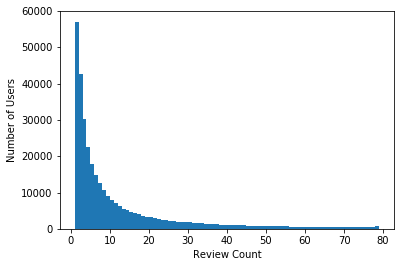

In [14]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda line:line['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** By plotting the histogram into log-log scale, it shows a linear relationship. This indicates the original one is Power Law. Reason: f(x)=ax^-k --> logf(x)=-k*log(ax)

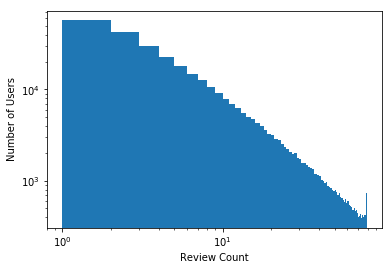

In [15]:
# TODO: Replace <FILL IN>

plt.hist(users_review_counts, bins=range(1,80),log=True)
plt.xlabel('Review Count')
plt.ylabel('Number of Users')
plt.xscale("log")

** Question: ** Plot the histogram of number of friends a Yelp user has.

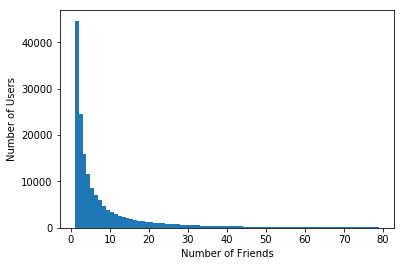

In [16]:
# TODO: Replace <FILL IN>

user_friend_counts = users_rdd.map(lambda line:len(line['friends'])).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** By plotting the histogram into log-log scale, it shows a linear relationship. This indicates the original one is Power Law. Reason: f(x)=ax^-k --> logf(x)=-k*log(ax)

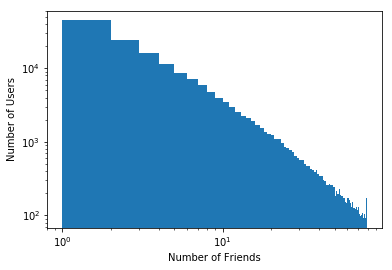

In [17]:
# TODO: Replace <FILL IN>

plt.hist(user_friend_counts, bins=range(1,80),log=True)
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.xscale("log")

** Question: ** Plot the histogram of number of fans a Yelp user has.

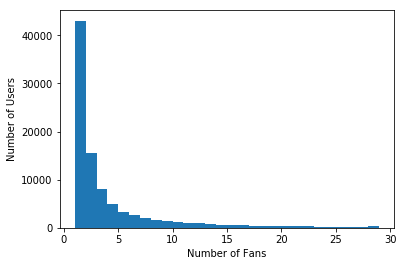

In [18]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda line:line['fans']).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** It is Power Law, showing linear relationship after plot it into log-log scale

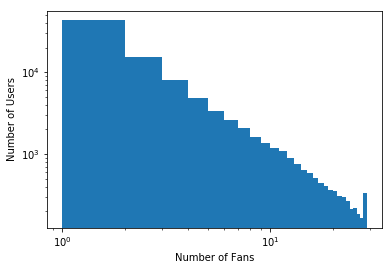

In [19]:
# TODO: Replace <FILL IN>

plt.hist(users_fan_counts, bins=range(1,30),log=True)
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')
plt.xscale("log")

** Question: ** Plot the histogram of number of checkins per Yelp business.

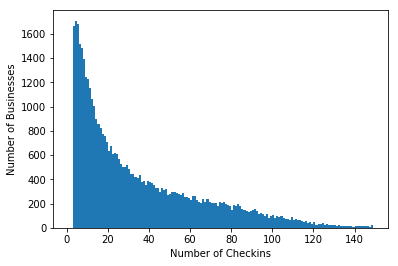

In [20]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda line:len(line['checkin_info'])).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** It is not a Power Law, the log-log scale histogram is not showing linear relationship

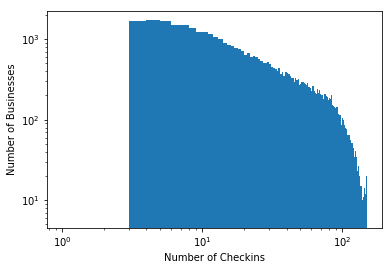

In [21]:
# TODO: Replace <FILL IN>

plt.hist(business_checkin_counts, bins=range(1,150),log=True)
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')
plt.xscale("log")

** Question: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [22]:
# TODO: Replace <FILL IN>

max_checkin_count = max(checkins_rdd.map(lambda line:len(line['checkin_info'])).collect())
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda line:len(line['checkin_info'])==max_checkin_count) \
    .map(lambda line:line['business_id']).collect()
len(business_ids_with_max_checkins)

41

In [23]:
# TODO: Replace <FILL IN>

business_names_with_max_checkins = businesses_rdd \
    .filter(lambda line:line['business_id'] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas'),
 ('McCarran International Airport', 'Las Vegas'),
 ('The California Hotel & Casino', 'Las Vegas'),
 ('Golden Nugget Hotel & Casino', 'Las Vegas'),
 ('Rio All Suites Hotel & Casino', 'Las Vegas'),
 ('24 Hour Fitness', 'Las Vegas'),
 ('Excalibur Hotel', 'Las Vegas'),
 ('Ellis Island Casino & Brewery', 'Las Vegas'),
 ('Las Vegas Athletic Club', 'Las Vegas'),
 ('Orleans Hotel & Casino', 'Las Vegas'),
 ('Palms Casino Resort', 'Las Vegas'),
 ('Bellagio Hotel', 'Las Vegas'),
 ('New York - New York', 'Las Vegas'),
 ('Paris Las Vegas Hotel & Casino', 'Las Vegas'),
 ('Monte Carlo Hotel And Casino', 'Las Vegas'),
 ('The Venetian Resort Hotel Casino', 'Las Vegas'),
 ('The Mirage', 'Las Vegas'),
 ('MGM Grand Hotel', 'Las Vegas'),
 ('Treasure Island, LLC', 'Las Vegas'),
 ('The Peppermill Restaurant & Fireside Lounge', 'Las Vegas'),
 ('Flamingo Las Vegas

** Question: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** Most of the checkins are in Las Vegas, this can be caused since Las Vegas has a larger tourist population and larger needs in restaurants.

** Question: ** Plot a histogram of the stars associated with business reviews.

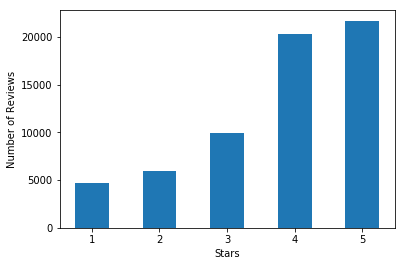

In [24]:
# TODO: Replace <FILL IN>

review_stars_counts = reviews_rdd.map(lambda line:line['stars']).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question: ** Plot a histogram of the number of reviews written per Yelp user.

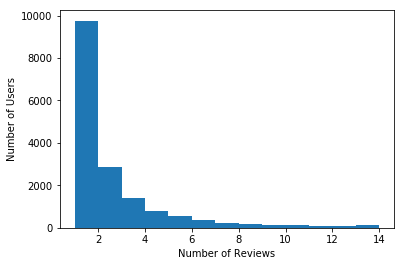

In [25]:
# TODO: Replace <FILL IN>

user_review_counts = list(reviews_rdd.map(lambda line:line['user_id']).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question: ** Plot a histogram of the number of reviews written per Yelp business.

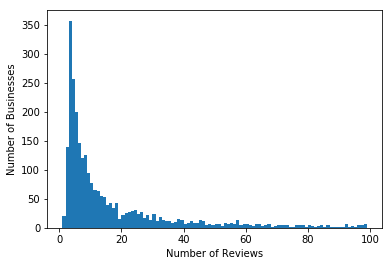

In [26]:
# TODO: Replace <FILL IN>

business_review_counts = list(reviews_rdd.map(lambda line:line['business_id']).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

** Question: ** Plot a histogram of the number of useful votes received by Yelp reviews.

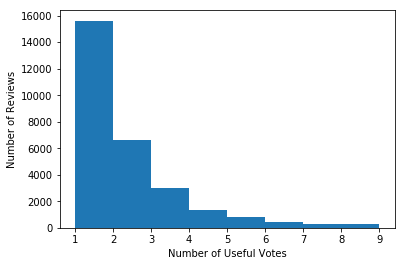

In [27]:
# TODO: Replace <FILL IN>

review_useful_counts = reviews_rdd.map(lambda line:line['votes']['useful']).collect()
plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question: ** Plot a histogram of the number of funny votes received by Yelp reviews.

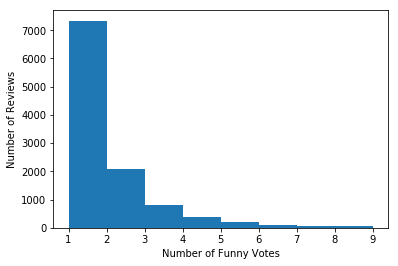

In [28]:
# TODO: Replace <FILL IN>

review_funny_counts = reviews_rdd.map(lambda line:line['votes']['funny']).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question: ** Plot a histogram of the number of cool votes received by Yelp reviews.

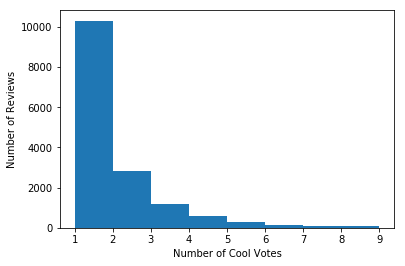

In [29]:
# TODO: Replace <FILL IN>

review_cool_counts = reviews_rdd.map(lambda line:line['votes']['cool']).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

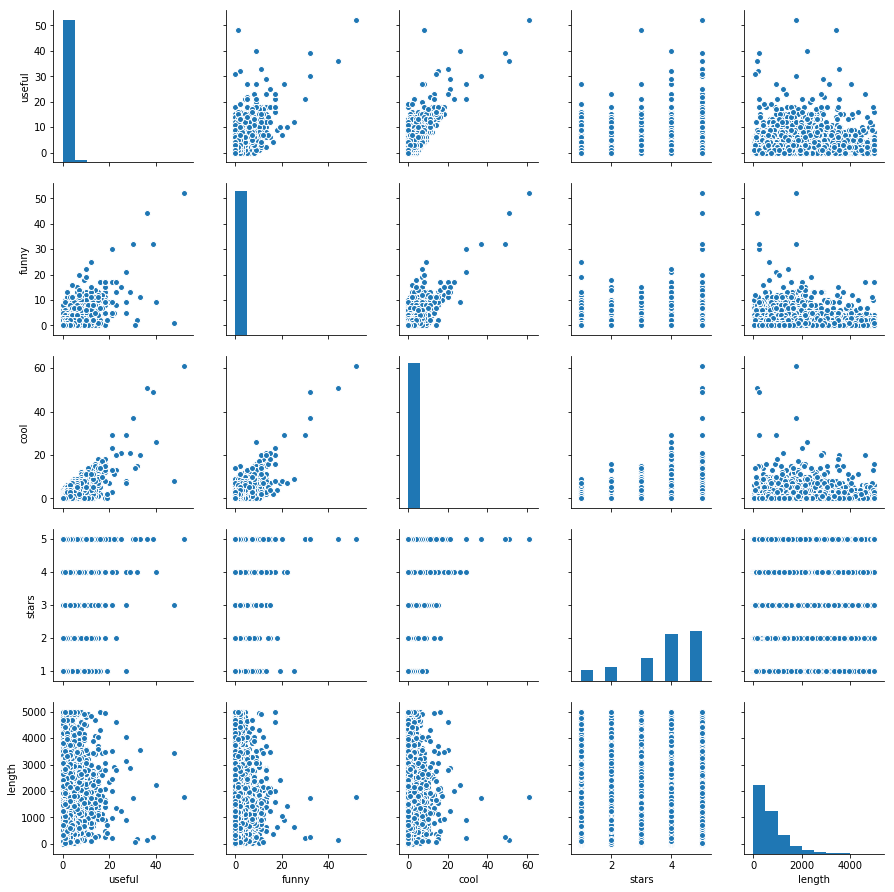

In [30]:
# TODO: Replace <FILL IN>

review_votes_length = reviews_rdd.map(lambda line:(line['votes']['useful'],line['votes']['funny'],line['votes']['cool'],line['stars'],len(line['text']))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [31]:
# TODO: Replace <FILL IN>

male_users = users_rdd.filter(lambda line:line['name'] in male_names)
female_users = users_rdd.filter(lambda line:line['name'] in female_names)

male_user_ids = male_users.map(lambda line:line['user_id']).collect()
female_user_ids = female_users.map(lambda line:line['user_id']).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869
366715


** Question: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [32]:
# TODO: Replace <FILL IN>

male_reviews = reviews_rdd.filter(lambda line:line['user_id'] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda line:line['user_id'] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda text:len(text))
female_word_count = female_reviews.map(lambda text:len(text))

print ('Male and female review length averages: ', male_word_count.mean(), female_word_count.mean())

Male and female review length averages:  697.3215248363517 760.4281720764145


** Question: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** From the plot below we can find that female are more like to write longer review, since the number of reviews to number of words are higher in female dimension than in male dimension. The trend for both male and female are increase first and decrease as the number of words increase.

In [33]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

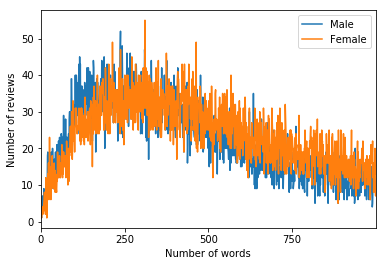

In [34]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [35]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

** Question: ** Fill in the necessary code to calculate word counts from text reviews below.

In [36]:
# TODO: Replace <FILL IN>

max_words = 10000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda r:r[0].split(" ")).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  10000


** Question: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [37]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [38]:
# TODO: Replace <FILL IN>
# the funny score and the corresponding review text word index
from collections import Counter
doc_vectors = all_reviews.map(lambda x: (x[1], x[0].lower().split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))    
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0],SparseVector(num_unique_words,sorted(set(x[1])),[x[1].count(i) for i in sorted(set(x[1]))])))
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (10000,[0,1,2,4,7,9,10,12,13,16,17,18,20,21,26,39,43,49,54,56,61,86,105,113,120,125,163,167,193,204,293,339,347,358,359,465,485,490,602,659,673,752,765,930,976,982,995,1086,1118,1437,1887,2245,2375,2834,2925,3210,3646,3892,4104,4282,4631,4726,5634,5912,6052],[8.0,3.0,1.0,5.0,5.0,1.0,1.0,1.0,2.0,5.0,6.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (10000,[0,4,6,9,10,18,20,36,37,42,45,55,76,81,88,100,109,110,131,200,239,298,313,323,358,373,387,442,465,602,639,903,926,976,2925,3470,6464,6595],[2.0,3.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


** Question: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [39]:
# TODO: Replace <FILL IN>

doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit([0.8,0.2],seed=244)

** Question: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [40]:
# TODO: Replace <FILL IN>

most_common_prediction = doc_vectors.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y)\
                                    .takeOrdered(1,lambda x:-x[1])[0][0]
labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 1.1966419115272844
Learned baseline prediction:  0.0


** Question: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [41]:
# TODO: Replace <FILL IN>

dt_model = DecisionTree.trainRegressor(doc_vectors_train,impurity='variance',maxDepth=5,categoricalFeaturesInfo={})

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

Validation Root Mean Squared Error (Decision Tree) = 1.0718046554520775
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 41 nodes
  If (feature 6 <= 3.0)
   If (feature 193 <= 6.0)
    If (feature 5158 <= 1.0)
     If (feature 2534 <= 1.0)
      If (feature 18 <= 0.0)
       Predict: 0.16473182707111056
      Else (feature 18 > 0.0)
       Predict: 0.27657464043643576
     Else (feature 2534 > 1.0)
      If (feature 1 <= 1.0)
       Predict: 25.0
      Else (feature 1 > 1.0)
       Predict: 0.5
    Else (feature 5158 > 1.0)
     If (feature 0 <= 2.0)
      Predict: 30.0
     Else (feature 0 > 2.0)
      Predict: 0.0
   Else (feature 193 > 6.0)
    If (feature 9455 <= 0.0)
     If (feature 800 <= 2.0)
      If (feature 614 <= 3.0)
       Predict: 0.48720089037284364
      Else (feature 614 > 3.0)
       Predict: 5.25
     Else (feature 800 > 2.0)
      Predict: 11.0
    Else (feature 9455 > 0.0)
     If (feature 4 <= 6.0)
      If (feature 0 <= 4.0)
       Pred

** Question: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [42]:
# TODO: Replace <FILL IN>

rf_model = RandomForest.trainRegressor(doc_vectors_train,impurity='variance',maxDepth=5,categoricalFeaturesInfo={},numTrees=10)

predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

Validation Root Mean Squared Error (Random Forest) = 1.0628873856385785
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 2812 <= 1.0)
     If (feature 6 <= 3.0)
      If (feature 18 <= 2.0)
       If (feature 193 <= 5.0)
        If (feature 3974 <= 3.0)
         Predict: 0.18254730127272165
        Else (feature 3974 > 3.0)
         Predict: 7.0
       Else (feature 193 > 5.0)
        If (feature 501 <= 2.0)
         Predict: 0.401318781264211
        Else (feature 501 > 2.0)
         Predict: 5.75
      Else (feature 18 > 2.0)
       If (feature 390 <= 2.0)
        If (feature 2115 <= 1.0)
         Predict: 0.4553415061295972
        Else (feature 2115 > 1.0)
         Predict: 5.2
       Else (feature 390 > 2.0)
        If (feature 10 <= 1.0)
         Predict: 5.0
        Else (feature 10 > 1.0)
         Predict: 4.0
     Else (feature 6 > 3.0)
      If (feature 6456 <= 1.0)
       If (feature 3864 <= 2.0)
        If (feature 8281 <= 2.

** Question: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: ** This will affect the number of tress in the ensemble, since gradient boosting tree build the tree one at a time during each iterations. compared to random forest, it sets the goal as reduce residule everytime in the iteration.Yes we can set the maximum depth of trees when we aims to avoid the overfitting situation in the model training, since it will generate the tree that can reduce the residules, so it might goes to an overfitting situation.

In [43]:
# TODO: Replace <FILL IN>

gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train,categoricalFeaturesInfo={},numIterations=10)

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

Validation Root Mean Squared Error (Gradient Boosting Trees) = 1.0674129883173447
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 6 <= 3.0)
     If (feature 193 <= 6.0)
      If (feature 5158 <= 1.0)
       Predict: 0.2029001549701129
      Else (feature 5158 > 1.0)
       Predict: 6.0
     Else (feature 193 > 6.0)
      If (feature 9455 <= 0.0)
       Predict: 0.495415393164768
      Else (feature 9455 > 0.0)
       Predict: 6.25
    Else (feature 6 > 3.0)
     If (feature 2922 <= 2.0)
      If (feature 1023 <= 2.0)
       Predict: 0.6025212491643587
      Else (feature 1023 > 2.0)
       Predict: 11.333333333333334
     Else (feature 2922 > 2.0)
      If (feature 0 <= 11.0)
       Predict: 1.0
      Else (feature 0 > 11.0)
       Predict: 52.0
  Tree 1:
    If (feature 18 <= 2.0)
     If (feature 212 <= 3.0)
      If (feature 422 <= 4.0)
       Predict: -0.06039442754362043
      Else (feature 422 > 4.0)
       Predict: 22.7949575016

** Question: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** (Baseline) = 1.1966419115272844;(Decision Tree) = 1.0718046554520775; (Random Forest) = 1.0628873856385785; (Gradient Boosting Trees) = 1.0674129883173447; 
The random forest has the best result, and the gradient boosting tree has a relatively similar performance.

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [44]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [45]:
# TODO: Replace <FILL IN>

review_user_ids = reviews_rdd.map(lambda line:line['user_id']).collect()
review_business_ids = reviews_rdd.map(lambda line:line['business_id']).collect()

user_to_index_dict = {review_user_ids[i]:i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]:i for i in range(len(review_business_ids))}

** Question: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [46]:
print(reviews_rdd.take(1))

[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}]


In [47]:
# TODO: Replace <FILL IN>

ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']], business_to_index_dict[x['business_id']], float(x['stars'])))
print(ratings_rdd.take(2))

[Rating(user=0, product=2, rating=5.0), Rating(user=59244, product=2, rating=2.0)]


** Question: ** Let us randomly split data into 80% train and 20% validation set.

In [50]:
# TODO: Replace <FILL IN>

ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8,0.2],seed=244)

** Question: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

In [51]:
# TODO: Replace <FILL IN>

numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train,rank,numIterations)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

Root Mean Squared Error (rank=1) = Train 2.8404541843638222, Validation 8.891194458135972
Root Mean Squared Error (rank=2) = Train 0.7470094030814289, Validation 2.861644486340258
Root Mean Squared Error (rank=3) = Train 0.6087856980543048, Validation 2.299774612552256
Root Mean Squared Error (rank=4) = Train 0.5855076907032567, Validation 2.567196680707573
Root Mean Squared Error (rank=5) = Train 0.4818442465408522, Validation 2.362294827261739
Root Mean Squared Error (rank=6) = Train 0.43993096266906906, Validation 2.2840692358642305
Root Mean Squared Error (rank=7) = Train 0.4013664360434528, Validation 2.1834647735335624
Root Mean Squared Error (rank=8) = Train 0.3738712018088061, Validation 2.194838307552568
Root Mean Squared Error (rank=9) = Train 0.35554358487117377, Validation 2.2804059063149698
Root Mean Squared Error (rank=10) = Train 0.33038028116552903, Validation 2.203740623181961
Root Mean Squared Error (rank=11) = Train 0.30530090952002303, Validation 2.169101787422431
R

** Question: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** I will choose rank = 25 as an option. The RMSE drop rapidly during 0 to 10, and being stable around 25. Also at this point the computation error won't be too high.

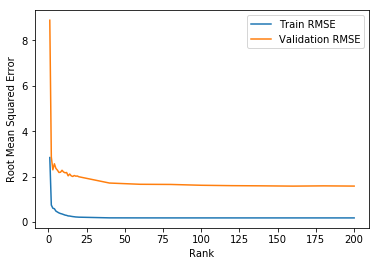

In [52]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Topic modeling for text reviews **

In this section, we will build and examine a Bayesian topic model named [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). The goal of textual topic modeling is to discover latent topics whose mixtures generate textual documents through a stylized probabilistic generatve model. The topics often have semantic meaning. They may be associated with various aspects discussed in the text corpus such as politics, health, education, etc. Topic models are unsupervised machine learning algorithms. Hence, the nature of discovered topics is entirely dependent of the context of your dataset.

In [53]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

** Question: ** Let us create a new RDD of just textual reviews from reviews_rdd, obtain word counts, and build a list of unique words that do not include stop words. Use num_stop_words as a measure of how many of the most frequent words to filter out.

In [54]:
# TODO: Replace <FILL IN>

# number of stopwords i.e. most frequent words to remove
# removal of stopwords such as a, the, from, etc. that occur across a vast majority of documents improves topic models
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda line:line['text'])
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
# sort words in descending order of frequency
word_counts = sorted(word_counts, key=lambda x:-x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  192742


** Question: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [55]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question: ** Construct an RDD of SparseVectors. Each SparseVector is built using the word counts of a review. Hence, the RDD of SparseVectors should be obtained as a map from the RDD of document word counts.

In [56]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
doc_vectors = doc_vectors.map(lambda x: SparseVector(num_unique_words,sorted(set(x)),[x.count(i) for i in sorted(set(x))]))
# zipWithIndex result needs a minor transform to be acceptable to the LDA training procedure
doc_vectors = doc_vectors.zipWithIndex().map(lambda x:[x[1],x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[[0, SparseVector(192742, {8: 2.0, 114: 1.0, 311: 1.0, 1209: 1.0, 1315: 1.0, 1444: 1.0, 1805: 1.0, 1987: 1.0, 2249: 1.0, 2738: 1.0, 2965: 1.0, 3148: 1.0, 3166: 1.0, 3530: 1.0, 3614: 1.0, 3977: 1.0, 4305: 1.0, 4391: 1.0, 4700: 1.0, 6041: 1.0, 8947: 1.0, 11064: 1.0, 13456: 1.0, 14371: 1.0, 23207: 1.0, 54812: 1.0, 77509: 1.0, 77510: 1.0, 77511: 1.0, 77512: 1.0})], [1, SparseVector(192742, {1805: 1.0, 2231: 1.0, 4799: 1.0, 5281: 1.0, 8776: 1.0, 12656: 1.0, 15459: 1.0, 17524: 1.0})]]


** Question: ** Train an LDA model with a 100 topics and the random seed set to 42.

In [58]:
# TODO: Replace <FILL IN>

lda_model = LDA.train(doc_vectors,k=100,seed=42)

** Question: ** Display the LDA model vocabulary size.

In [59]:
# TODO: Replace <FILL IN>

print('Model vocabulary size: ', lda_model.vocabSize())

Model vocabulary size:  192742


** Question: ** Display 5 learned topics and the top 100 terms that appear in each of these topics. Assign a semantic label/meaning to each of them (e.g. food, ambience, drinks, service, etc.) You can access the topic matrix using the function topicsMatrix on the model. Do the topics learned from Yelp reviews look representative of the corpus?

In [64]:
# TODO: Replace <FILL IN>

topics=lda_model.topicsMatrix()
for i in range(5):
    index=lda_model.describeTopics(100)[i][0]
    print(i)
    print([index_to_word_dict[x] for x in index])

0
['rooms', 'wall', 'up,', 'choices', 'noodle', 'sign', 'pepper', 'best.', 'somewhere', 'limited', 'share', "they've", 'is,', "you'd", 'forget', 'recent', 'generally', 'greasy', 'bottom', 'general', 'covered', 'charge', 'atmosphere,', 'paying', 'except', 'pancakes', 'great!', 'finished', 'oil', 'thank', 'room.', 'dressing', 'seriously', 'hand', 'you,', 'thick', 'tasty,', 'thin', 'and,', 'fresh.', 'clearly', 'sour', 'else.', 'life', 'toast', 'thinking', 'means', 'mine', 'bread.', 'honestly', 'terrible', 'recommended', 'side,', 'wait.', 'corner', 'bars', 'true', "we're", 'longer', 'personal', 'area,', 'meal,', '(not', 'pizza,', 'small,', 'veggies', 'foods', 'selection.', 'location.', 'special.', 'please', 'cook', 'delivery', 'bean', 'prices.', 'times.', 'perfect.', 'avoid', 'apple', 'pricey', 'employees', 'works', 'oh,', 'picked', 'minute', 'multiple', 'inside.', 'stayed', 'dishes.', 'greeted', 'visit.', 'banana', 'unfortunately', 'burger.', 'wedding', 'total', 'kinda', 'amazing!', 'pump

# ** Part 5: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [61]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [62]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [65]:
# TODO: Replace <FILL IN>

word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).fit(review_docs)

Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [66]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['goodness', 'concoction', 'vinegar', 'americano', 'rub']
Words most similar to  pepper  :  ['mayo', 'tomato', 'sriracha', 'garnish', 'spear']
Words most similar to  restaurant  :  ['location', 'osteria', 'establishment', 'tis', 'bistro']
Words most similar to  italian  :  ['lebanese', 'american', 'pizza', 'style', 'cham']
Words most similar to  indian  :  ['mexican', 'chinese', 'cuisine', 'vietnamese', 'asian']
Words most similar to  chinese  :  ['mexican', 'indian', 'asian', 'cuisine', 'japanese']
Words most similar to  direction  :  ['germs', 'blemish', 'freeway', 'fade', 'meander']
Words most similar to  pittsburgh  :  ['pgh', 'nyc', 'town', 'shadyside', 'oakland']
Words most similar to  burgh  :  ['city', 'delicatessen', 'strip', 'prettiest', 'lebanon']
Words most similar to  city  :  ['burgh', 'pa', 'washington', 'strip', 'prettiest']
Words most similar to  location  :  ['restaurant', 'neighborhood', 'scene', 'studio', 'cafe']
Words most similar to

** Question: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: ** There are several synonyms, salt and vinegar, pittsburgh and pgh and shadyside, etc. While there are words spurious, such as pizza and mongolian, cmu and perspective, are strongly related.

# ** Part 6: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [67]:
from pyspark.mllib.fpm import FPGrowth

** Question: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [68]:
# TODO: Replace <FILL IN>

business_categories = businesses_rdd.map(lambda line:line['categories'])

fpgrowth_model = FPGrowth.train(business_categories,0.01,10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [70]:
# TODO: Replace <FILL IN>

fpgrowth_model = FPGrowth.train(business_categories,0.001,10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: ** No. The first several items set are included, but the later part is not included.

# ** Part 7: Bonus Analysis (if any) **

Here, you can include any additional and insightful exploratory data analysis or machine learning tasks you have carried out in addition to the guided exploration of the dataset above. Feel free to add code/markdown cells here to present your analysis.